In [ ]:
from package_hybrid_ansatz import *
import numpy as np
from pyscf import gto, scf, ci, cc, mcscf, fci

chemical_accuracy = 0.0016  # hartree

# LiH

In [22]:
distances = np.arange(0.1, 3.01, 0.01)
basis = 'sto-3g'
multiplicity = 1
charge = 0


results = {'distances': distances, 'HF': [], 'CISD': [], 'CCSD': [], 'CCSD(T)': [], 'FCI': []}

for dist in distances:
    geometry = [['Li', (0., 0., 0.)], ['H', (0., 0., dist)]]
    molecule = MolecularData(geometry, basis, multiplicity, charge)
    molecule = run_pyscf(molecule, run_scf=True, run_cisd=True, run_ccsd=True, run_fci=True)
    
    results['HF'].append(molecule.hf_energy)
    results['CISD'].append(molecule.cisd_energy)
    pyscf_ccsd = molecule._pyscf_data['ccsd']
    results['CCSD'].append(pyscf_ccsd.e_tot)
    results['CCSD(T)'].append(pyscf_ccsd.e_tot + pyscf_ccsd.ccsd_t())
    results['FCI'].append(molecule.fci_energy)


np.savez('data/LiH_scf_energies.npz', **results)

# N2

## 12 qubits (4 frozen orbits)

In [ ]:
# scan distances
distances = np.arange(0.6, 2.31, 0.01)
#distances = np.array([2.1])
basis = 'sto-3g'
spin = 0   # multiplicity=1 -> spin=0
charge = 0
frozen =  4  # 3, 4

results = {'distances': distances, 'HF': [], 'CISD': [], 'CCSD': [], 'CCSD(T)': [], 'FCI': []}

for dist in tqdm(distances, desc="Progress"):
    mol = gto.M(
        atom = f'N 0 0 0; N 0 0 {dist}',
        basis = basis,
        spin = spin,
        charge = charge,
        verbose = 0
    )

    # Hartree–Fock
    mf = scf.RHF(mol).run()
    hf_energy = mf.e_tot

    # CISD
    myci = ci.CISD(mf, frozen=frozen).run()
    cisd_energy = myci.e_tot

    # CCSD
    mycc = cc.CCSD(mf, frozen=frozen)#.run()
    if dist >= 2.0:
        mycc.diis = True
        mycc.diis_space = 12
        mycc.diis_start_cycle = 4
        mycc.conv_tol = 1e-10
        mycc.level_shift = 0.3
        mycc.max_cycle = 300
        mycc.damp = 0.2
    mycc = mycc.run()
    ccsd_energy = mycc.e_tot

    # CCSD(T)
    ccsdt_energy = mycc.e_tot + mycc.ccsd_t()

    # FCI
    ncore = frozen
    nmo = mf.mo_coeff.shape[1]
    ncas = nmo - ncore
    nelecas = mol.nelectron - 2 * ncore
    mc = mcscf.CASCI(mf, ncas, nelecas)
    mc.ncore = ncore          
    fci_energy = mc.kernel()[0]   


    results['HF'].append(hf_energy)
    results['CISD'].append(cisd_energy)
    results['CCSD'].append(ccsd_energy)
    results['CCSD(T)'].append(ccsdt_energy)
    results['FCI'].append(fci_energy)

    print("HF energy: ", hf_energy)
    print("CISD energy: ", cisd_energy)
    print("CCSD energy: ", ccsd_energy)
    print("CCSD(T) energy: ", ccsdt_energy)
    print("FCI energy: ", fci_energy)

# save
np.savez('data/N2-12_qubit-scf_energies.npz', **results)


## 20 qubits (full space)

In [ ]:
# scan distances
distances = np.arange(0.1, 3.01, 0.6)
#distances = np.array([1.5])
basis = 'sto-3g'
spin = 0   # multiplicity=1 -> spin=0
charge = 0

results = {'distances': distances, 'HF': [], 'CISD': [], 'CCSD': [], 'CCSD(T)': [], 'FCI': []}

for dist in tqdm(distances, desc="Progress"):
    mol = gto.M(
        atom = f'N 0 0 0; N 0 0 {dist}',
        basis = basis,
        spin = spin,
        charge = charge,
        verbose = 0
    )

    # Hartree–Fock
    mf = scf.RHF(mol).run()
    hf_energy = mf.e_tot

    # CISD
    myci = ci.CISD(mf).run()
    cisd_energy = myci.e_tot

    # CCSD
    mycc = cc.CCSD(mf).run()
    ccsd_energy = mycc.e_tot

    # CCSD(T)
    ccsdt_energy = mycc.e_tot + mycc.ccsd_t()

    # FCI
    cisolver = fci.FCI(mf)
    fci_energy = cisolver.kernel()[0]


    results['HF'].append(hf_energy)
    results['CISD'].append(cisd_energy)
    results['CCSD'].append(ccsd_energy)
    results['CCSD(T)'].append(ccsdt_energy)
    results['FCI'].append(fci_energy)

    print("HF energy: ", hf_energy)
    print("CISD energy: ", cisd_energy)
    print("CCSD energy: ", ccsd_energy)
    print("CCSD(T) energy: ", ccsdt_energy)
    print("FCI energy: ", fci_energy)

np.savez('data/N2_scf_energies_pyscf.npz', **results)


# Plot

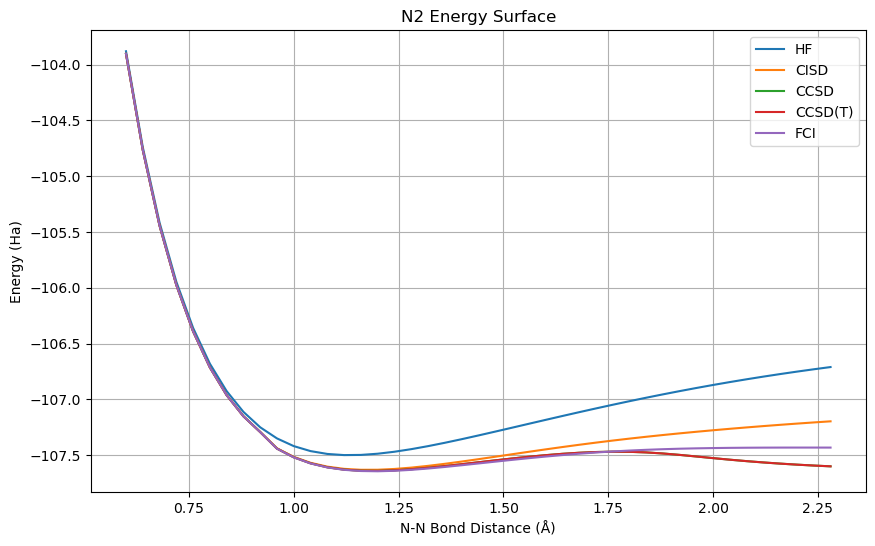

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# load data
with np.load('data/N2-12_qubit-scf_energies.npz') as data:  # 'data/N2-scf_energies.npz'
    dist = data['distances']
    hf = data['HF']
    cisd = data['CISD']
    ccsd = data['CCSD']
    ccsdt = data['CCSD(T)']
    fci = data['FCI']

# draw energy surface
step = 4  
plt.figure(figsize=(10, 6))
plt.plot(dist[::step], hf[::step], label='HF')
plt.plot(dist[::step], cisd[::step], label='CISD')
plt.plot(dist[::step], ccsd[::step], label='CCSD')
plt.plot(dist[::step], ccsdt[::step], label='CCSD(T)')
plt.plot(dist[::step], fci[::step], label='FCI')
plt.xlabel('N-N Bond Distance (Å)')
plt.ylabel('Energy (Ha)')
plt.title('N2 Energy Surface')
plt.legend()
plt.grid(True)
plt.show()

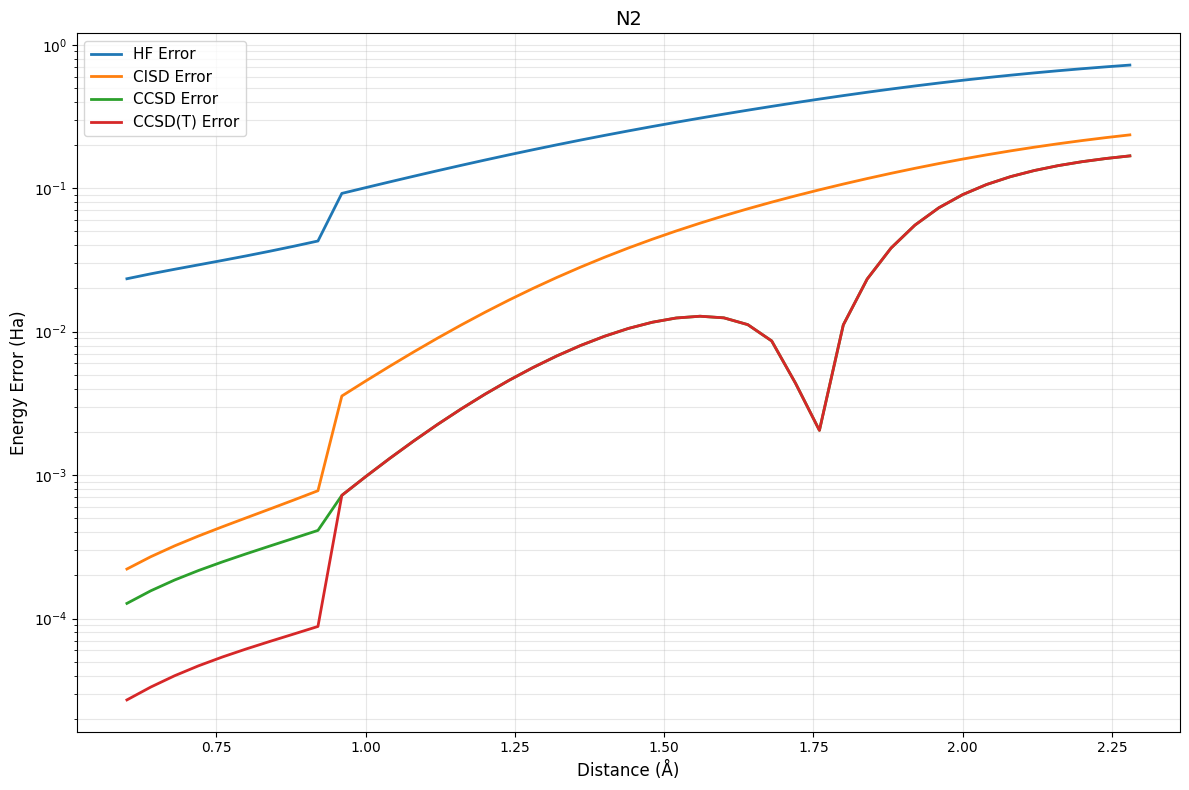

In [8]:
# load data
step = 4
with np.load('data/N2-12_qubit-scf_energies.npz') as data:  # 'data/N2-scf_energies.npz'
    dist = data['distances'][::step]
    hf = data['HF'][::step]
    cisd = data['CISD'][::step]
    ccsd = data['CCSD'][::step]
    ccsdt = data['CCSD(T)'][::step]
    fci = data['FCI'][::step]

# calculate energy errors
hf_error = np.abs(hf - fci)
cisd_error = np.abs(cisd - fci)
ccsd_error = np.abs(ccsd - fci)
ccsdt_error = np.abs(ccsdt - fci)


plt.figure(figsize=(12, 8))
plt.semilogy(dist, hf_error, linewidth=2, markersize=4, label='HF Error')
plt.semilogy(dist, cisd_error, linewidth=2, markersize=4, label='CISD Error')
plt.semilogy(dist, ccsd_error, linewidth=2, markersize=4, label='CCSD Error')
plt.semilogy(dist, ccsdt_error, linewidth=2, markersize=4, label='CCSD(T) Error')

plt.xlabel('Distance (Å)', fontsize=12)
plt.ylabel('Energy Error (Ha)', fontsize=12)
plt.title('N2', fontsize=14)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3, which='both')  

plt.tight_layout()
plt.show()